In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
import io

In [3]:
qpcr_results = pd.read_excel("./20200403 Zymo Extraction_data.xls", sheet_name="Results", skiprows=7, na_values=['Undetermined'])
qpcr_results.head()

,Well,Sample Name,Target Name,Task,Reporter,Quencher,Cт,Cт Mean,Cт SD,Quantity,...,Quantity SD,Automatic Ct Threshold,Ct Threshold,Automatic Baseline,Baseline Start,Baseline End,Comments,HIGHSD,NOAMP,EXPFAIL
0,A1,Sample 1,IECRNA,UNKNOWN,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,NaN,1.0,0.007157,1.0,3.0,39.0,NaN,Y,Y,Y
1,A1,Sample 1,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,26.962109,26.601562,0.509889,701.766296,...,295.177429,1.0,0.020295,1.0,3.0,26.0,NaN,Y,Y,Y
2,A2,Sample 9,IECRNA,UNKNOWN,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,NaN,1.0,0.007157,1.0,3.0,39.0,NaN,N,Y,Y
3,A2,Sample 9,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,30.920759,30.860313,0.085485,54.113476,...,3.114707,1.0,0.020295,1.0,3.0,29.0,NaN,N,Y,Y
4,A3,Sample 17,IECRNA,UNKNOWN,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,NaN,1.0,0.007157,1.0,3.0,39.0,NaN,N,Y,Y


In [44]:
qpcr_results['Sample Number'] = qpcr_results['Sample Name'].str.replace(r'Sample ([0-9]+)', r'\1').astype(np.float)

# Standard Curve

In [4]:
qpcr_results['Task'].dropna().str.contains('STANDARD')

0      False
1      False
2      False
3      False
4      False
       ...  
138    False
139    False
140    False
141    False
142    False
Name: Task, Length: 143, dtype: bool

In [5]:
sc = qpcr_results[qpcr_results['Task'].str.contains('STANDARD', na=False)]

In [6]:
sc[['Well','Sample Name', 'Cт', 'Quantity']]

,Well,Sample Name,Cт,Quantity
15,A10,NaN,15.670425,1000000.0
16,A11,NaN,15.683854,1000000.0
17,A12,NaN,15.831069,1000000.0
33,B10,NaN,19.347982,100000.0
34,B11,NaN,19.338932,100000.0
35,B12,NaN,19.242029,100000.0
51,C10,NaN,22.542189,10000.0
52,C11,NaN,22.748108,10000.0
53,C12,NaN,22.377283,10000.0
69,D10,NaN,26.219810,1000.0


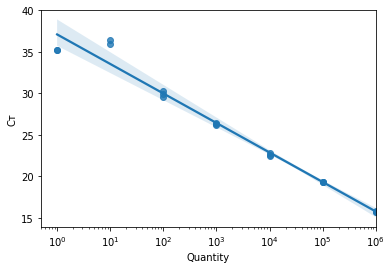

In [7]:
ax = sns.regplot(data=sc, x='Quantity', y='Cт', logx=True)
ax.set_xscale('log')

In [32]:
results = smf.ols('Cт ~ np.log10(Quantity)', data=sc).fit()
results.summary()

/Users/anton/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Cт   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     680.9
Date:                Tue, 07 Apr 2020   Prob (F-statistic):           3.73e-15
Time:                        17:37:23   Log-Likelihood:                -28.359
No. Observations:                  19   AIC:                             60.72
Df Residuals:                      17   BIC:                             62.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.0864      0.516     71.902      0.000      35.998      38.175
np.log10(Quantity)    -3.5571      0.136    -26.093      0.000      -3.845      -3.269
==============================================================================
Omnibus:                        9.035   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                6.531
Skew:                           1.014   Prob(JB):                       0.0382
Kurtosis:                       5.034   Cond. No.                         7.87
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[]

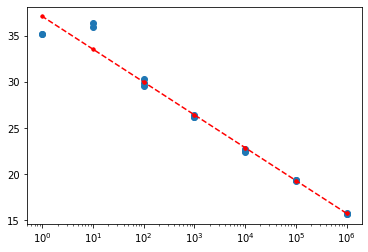

In [33]:
plt.scatter(sc.loc[results.fittedvalues.index, 'Quantity'], sc.loc[results.fittedvalues.index, 'Cт'])
plt.plot(sc.loc[results.fittedvalues.index, 'Quantity'], results.fittedvalues, 'r--.', label="OLS")
plt.semilogx()

In [36]:
results.params['np.log10(Quantity)']

-3.5571070754636045

In [39]:
# efficiency
print("Efficiency: {:.2%}".format(10**(-1 / results.params['np.log10(Quantity)']) - 1))

Efficiency: 91.04%


In [41]:
negs = qpcr_results.loc[qpcr_results['Task'].str.contains('NTC', na=False)]
negs

,Well,Sample Name,Target Name,Task,Reporter,Quencher,Cт,Cт Mean,Cт SD,Quantity,...,Quantity SD,Automatic Ct Threshold,Ct Threshold,Automatic Baseline,Baseline Start,Baseline End,Comments,HIGHSD,NOAMP,EXPFAIL
141,H10,NaN,IECRNA,NTC,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,NaN,1.0,0.007157,1.0,3.0,39.0,NaN,N,N,N
142,H10,NaN,SARS-CoV-2,NTC,FAM,NFQ-MGB,NaN,NaN,NaN,NaN,...,NaN,1.0,0.020295,1.0,3.0,38.0,NaN,N,N,N


# Endogenous Controls

In [47]:
endo = qpcr_results[qpcr_results['Target Name'] == "RNAseP"]
endo.sort_values('Sample Number')[['Sample Name', 'Cт']]

,Sample Name,Cт
12,Sample 1,24.382830
30,Sample 2,25.965197
48,Sample 3,24.200281
66,Sample 4,23.538330
84,Sample 5,23.876665
102,Sample 6,25.944221
120,Sample 7,23.070375
138,Sample 8,24.728588
13,Sample 9,23.727480
31,Sample 10,23.025755


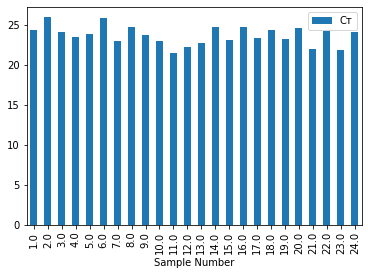

In [49]:
endo.sort_values(by=['Sample Number']).plot.bar(x='Sample Number', y='Cт')

In [51]:
endo['Cт'].describe()

count    24.000000
mean     23.732212
std       1.178089
min      21.484003
25%      23.059220
50%      23.802073
75%      24.445460
max      25.965197
Name: Cт, dtype: float64

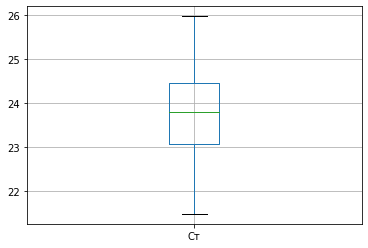

In [54]:
endo.boxplot(column='Cт')

# CoV

In [56]:
ncov = qpcr_results[qpcr_results['Target Name'] == 'SARS-CoV-2']

In [60]:
sample_data = '''
Sample Number	NP Sample	"Spike"	Control	"Control Conc"	"Volume"
1		30.00	PCD 3	2.00E+03	15
2		30.00	PCD 3	2.00E+03	15
3		30.00	PCD 3	2.00E+03	15
4		10.00	PCD 3	2.00E+03	5
5		10.00	PCD 3	2.00E+03	5
6		10.00	PCD 3	2.00E+03	5
7		2.00	PCD 3	2.00E+03	1
8		2.00	PCD 3	2.00E+03	1
9		2.00	PCD 3	2.00E+03	1
10		1.00	PCD 4	2.00E+02	5
11		1.00	PCD 4	2.00E+02	5
12		1.00	PCD 4	2.00E+02	5
13		0.50	PCD 4	2.00E+02	2.5
14		0.50	PCD 4	2.00E+02	2.5
15		0.50	PCD 4	2.00E+02	2.5
16		0.20	PCD 4	2.00E+02	1
17		0.20	PCD 4	2.00E+02	1
18		0.20	PCD 4	2.00E+02	1
19		0.10	PCD 5	2.00E+01	5
20		0.10	PCD 5	2.00E+01	5
21		0.10	PCD 5	2.00E+01	5
22		0.00	NEG		0
23		0.00	NEG		0
24		0.00	NEG		0'''

sample_data = pd.read_table(io.StringIO(sample_data))
ncov = ncov.merge(sample_data)

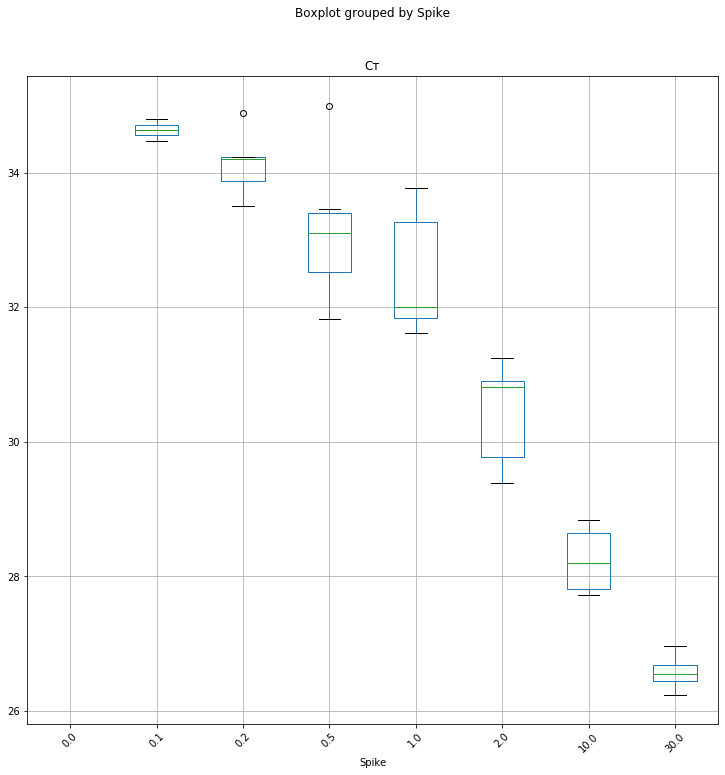

In [61]:
ncov.boxplot(by='Spike', column='Cт', rot=45, figsize=(12,12))

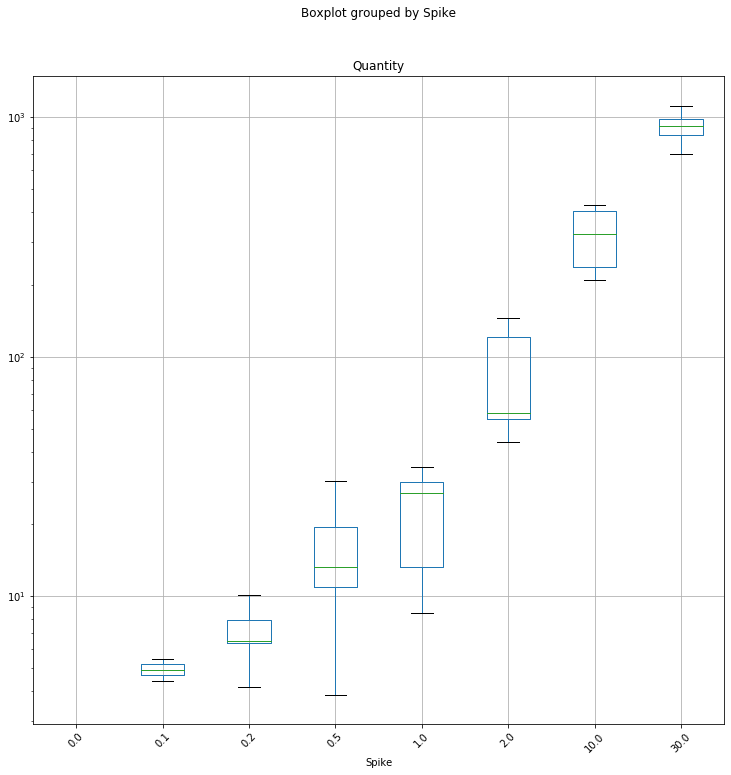

In [83]:
ax = ncov.boxplot(by='Spike', column='Quantity', rot=45, figsize=(12,12))
ax.set_yscale('log')

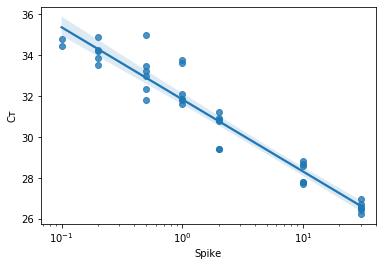

In [76]:
ax = sns.regplot(data=ncov, x='Spike', y='Cт', logx=True)
ax.set_xscale('log')

In [93]:
ncov.head()

,Well,Sample Name,Target Name,Task,Reporter,Quencher,Cт,Cт Mean,Cт SD,Quantity,...,NOAMP,EXPFAIL,Sample Number,NP Sample,Spike,Control,Control Conc,Volume,RNA Input,Yield
0,A1,Sample 1,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,26.962109,26.601562,0.509889,701.766296,...,Y,Y,1.0,NaN,30.0,PCD 3,2000.0,15.0,2000.000000,0.350883
1,A4,Sample 1,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,26.241016,26.601562,0.509889,1119.210205,...,Y,Y,1.0,NaN,30.0,PCD 3,2000.0,15.0,2000.000000,0.559605
2,A2,Sample 9,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,30.920759,30.860313,0.085485,54.113476,...,Y,Y,9.0,NaN,2.0,PCD 3,2000.0,1.0,133.333333,0.405851
3,A5,Sample 9,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,30.799866,30.860313,0.085485,58.518337,...,Y,Y,9.0,NaN,2.0,PCD 3,2000.0,1.0,133.333333,0.438888
4,A3,Sample 17,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,33.880699,33.695599,0.261772,7.964963,...,Y,Y,17.0,NaN,0.2,PCD 4,200.0,1.0,13.333333,0.597372


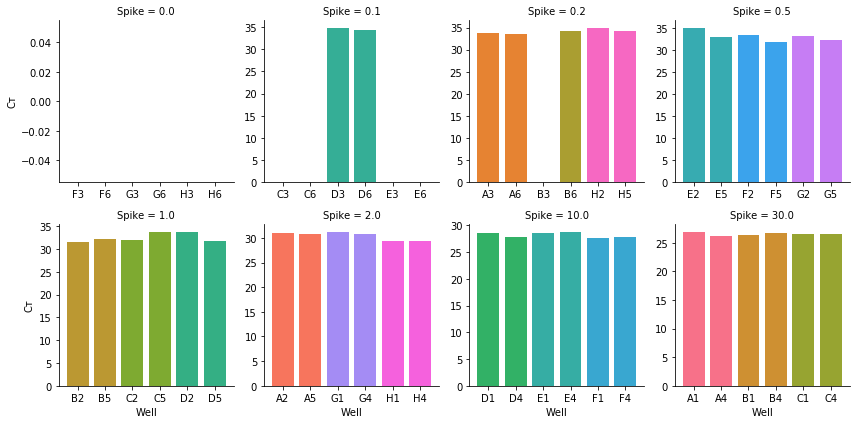

In [110]:
# ncov.groupby('Sample Name').plot.bar(x="Well", y="Cт")
g = sns.FacetGrid(ncov.fillna(0), col="Spike", col_wrap=4, hue="Sample Name", sharex=False, sharey=False)
g.map(plt.bar, "Well", "Cт")

## Yield

In [65]:
ncov['RNA Input'] = ncov['Spike'] * 400 / 30 * 5

In [66]:
ncov.loc[:,'Yield'] = ncov['Quantity'] / ncov['RNA Input']

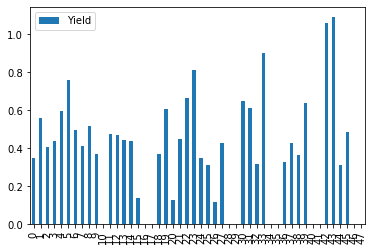

In [67]:
ncov[['Sample Name','Yield']].plot.bar()

In [70]:
ncov[ncov['Yield'] < 1]['Yield'].describe()

count    35.000000
mean      0.461373
std       0.177164
min       0.116035
25%       0.357261
50%       0.438888
75%       0.578489
max       0.903384
Name: Yield, dtype: float64

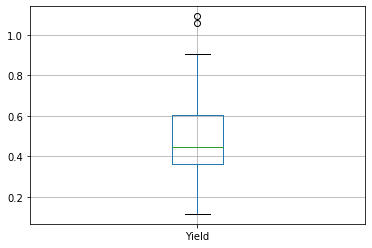

In [72]:
ncov.boxplot(column='Yield')

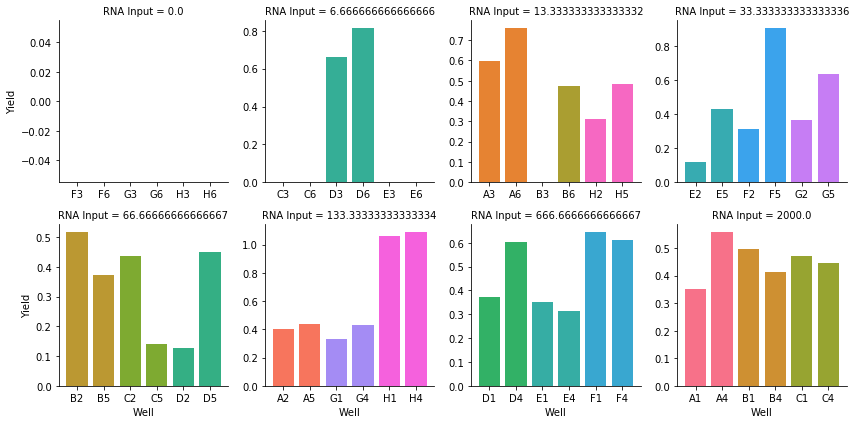

In [113]:
g = sns.FacetGrid(ncov.fillna(0), col="RNA Input", col_wrap=4, hue="Sample Name", sharex=False, sharey=False)
g.map(plt.bar, "Well", "Yield")

## Diag

In [114]:
qpcr_results.head()

,Well,Sample Name,Target Name,Task,Reporter,Quencher,Cт,Cт Mean,Cт SD,Quantity,...,Automatic Ct Threshold,Ct Threshold,Automatic Baseline,Baseline Start,Baseline End,Comments,HIGHSD,NOAMP,EXPFAIL,Sample Number
0,A1,Sample 1,IECRNA,UNKNOWN,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,1.0,0.007157,1.0,3.0,39.0,NaN,Y,Y,Y,1.0
1,A1,Sample 1,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,26.962109,26.601562,0.509889,701.766296,...,1.0,0.020295,1.0,3.0,26.0,NaN,Y,Y,Y,1.0
2,A2,Sample 9,IECRNA,UNKNOWN,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,1.0,0.007157,1.0,3.0,39.0,NaN,N,Y,Y,9.0
3,A2,Sample 9,SARS-CoV-2,UNKNOWN,FAM,NFQ-MGB,30.920759,30.860313,0.085485,54.113476,...,1.0,0.020295,1.0,3.0,29.0,NaN,N,Y,Y,9.0
4,A3,Sample 17,IECRNA,UNKNOWN,VIC,NFQ-MGB,NaN,NaN,NaN,NaN,...,1.0,0.007157,1.0,3.0,39.0,NaN,N,Y,Y,17.0


In [131]:
ierc = qpcr_results[(qpcr_results['Target Name'] == 'IECRNA')]

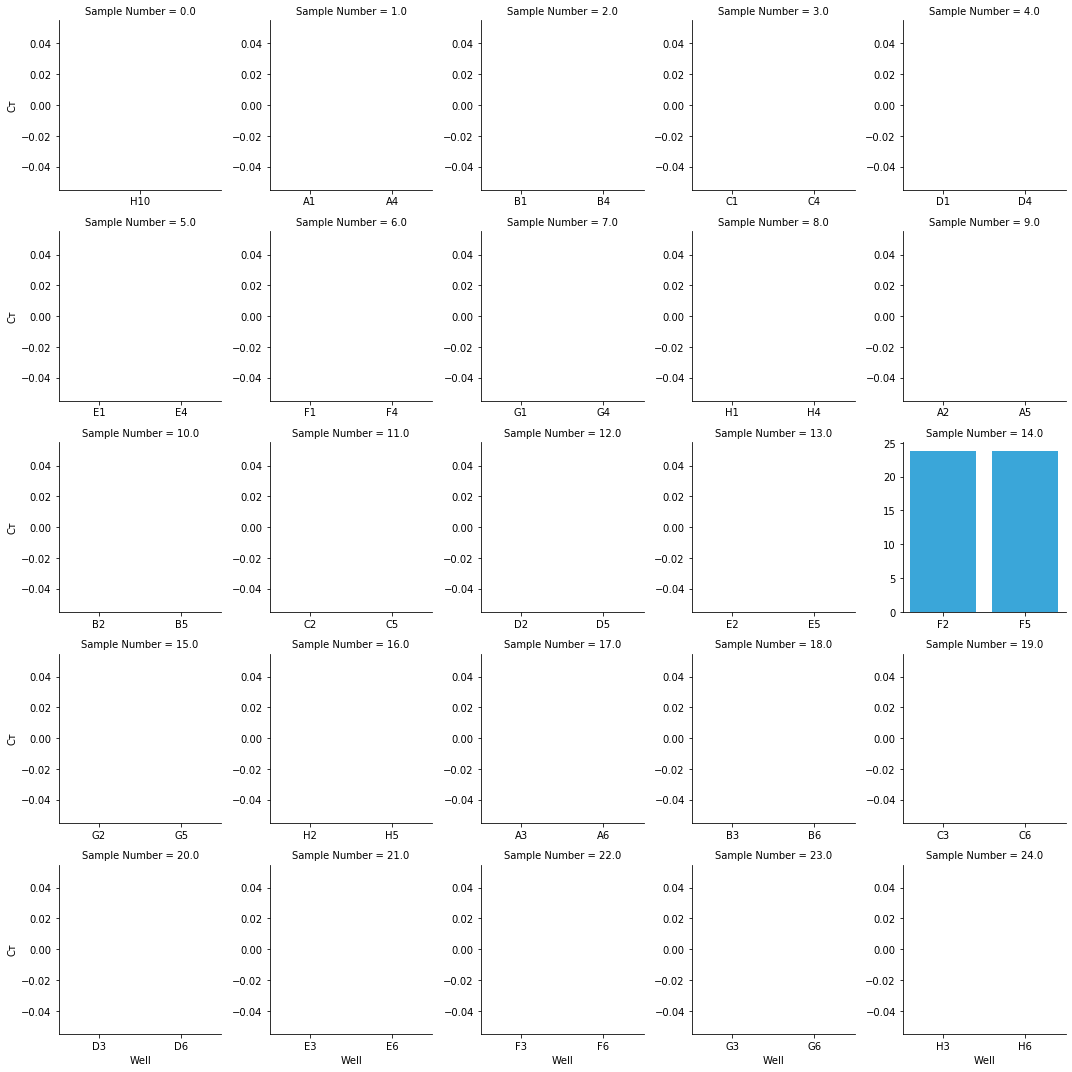

In [122]:
g = sns.FacetGrid(ierc.fillna(0), col="Sample Number", col_wrap=5, hue="Sample Name", sharex=False, sharey=False)
g.map(plt.bar, "Well", "Cт")

In [124]:
ierc['Cт'].fillna(0).describe()

count    49.000000
mean      0.972022
std       4.760886
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max      23.843004
Name: Cт, dtype: float64

In [132]:
ierc.sort_values(by='Sample Number')[['Sample Name','Cт', 'NOAMP']]

,Sample Name,Cт,NOAMP
0,Sample 1,NaN,Y
6,Sample 1,NaN,Y
24,Sample 2,NaN,Y
18,Sample 2,NaN,Y
42,Sample 3,NaN,Y
36,Sample 3,NaN,Y
60,Sample 4,NaN,Y
54,Sample 4,NaN,Y
72,Sample 5,NaN,Y
78,Sample 5,NaN,Y


In [134]:
qpcr_results[qpcr_results['Target Name'] == "SARS-CoV-2"][['Sample Name','NOAMP']]

,Sample Name,NOAMP
1,Sample 1,Y
3,Sample 9,Y
5,Sample 17,Y
7,Sample 1,Y
9,Sample 9,Y
...,...,...
131,Sample 24,Y
133,Sample 8,Y
135,Sample 16,Y
137,Sample 24,Y


In [148]:
diags = list()
for well in qpcr_results[qpcr_results['Sample Name'].str.contains('Sample', na=False) & qpcr_results['Target Name'].str.contains('SARS-CoV-2', na=False)]['Well'].unique():
    sample_data = qpcr_results[qpcr_results['Well'] == well].set_index('Target Name')
    sample_data['Cт'] = sample_data['Cт'].fillna(np.inf)
    
    ierc = sample_data.loc['IECRNA']
    ncov = sample_data.loc['SARS-CoV-2']
    
    result = {
        'Sample Name': ncov['Sample Name'], 
        'Result': 'Unknown', 
        'Type': 'Unknown', 
        'CT': ncov['Cт'], 
        'Quantity': ncov['Quantity'],
        'IECRNA CT': ierc['Cт']}
        
    if ncov['Cт'] < 50:
        result['Result'] = 'Positive'
        if ncov['Cт'] <= 30 or ierc['Cт'] < 50:
            result['Type'] = 'Quantitative'
        elif ncov['Cт'] > 30 and ierc['Cт'] < 50:
            result['Type'] = 'Qualitative'
    else:
        if ierc['Cт'] < 50:
            result['Result'] = 'Negative'
            result['Type'] = 'Qualitative'
        else:
            result['Type'] = 'Sample Failure'
            
    diags.append(result)
            
diags = pd.DataFrame(diags)
diags.sort_values('Sample Name')

,Sample Name,Result,Type,CT,Quantity,IECRNA CT
0,Sample 1,Positive,Quantitative,26.962109,701.766296,inf
3,Sample 1,Positive,Quantitative,26.241016,1119.210205,inf
7,Sample 10,Positive,Unknown,31.613691,34.554363,inf
10,Sample 10,Positive,Unknown,32.126579,24.792242,inf
16,Sample 11,Positive,Unknown,33.637756,9.321414,inf
13,Sample 11,Positive,Unknown,31.872898,29.216801,inf
19,Sample 12,Positive,Unknown,33.776600,8.520185,inf
22,Sample 12,Positive,Unknown,31.833031,29.980612,inf
25,Sample 13,Positive,Unknown,34.996624,3.867820,inf
28,Sample 13,Positive,Unknown,32.975746,14.308408,inf


In [145]:
plate = diags.merge(qpcr_results.loc[qpcr_results['Target Name'] == 'SARS-CoV-2',['Sample Name', 'Well']])
plate['Column'] = plate['Well'].str[1:]
plate['Row'] = plate['Well'].str[:1]
plate = plate.pivot(index='Row', columns='Column', values='Result')
plate.to_clipboard()
plate

ValueError: Index contains duplicate entries, cannot reshape